In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import RandomizedSearchCV


In [2]:
#functions to predict and check accuray
def AccuracyScore(model, x_valid, y_valid):
    y_pred = model.predict(x_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return accuracy


In [3]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [4]:
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')


In [5]:
test_label1=test_data.copy()
id=test_label1["ID"]

In [6]:
X_train = train_data.drop(columns=["label_1", "label_2", "label_3", "label_4"])
y_test_train = train_data["label_1"]

X_valid = valid_data.drop(columns=["label_1", "label_2", "label_3", "label_4"])
Y_valid = valid_data["label_1"]

X_test = valid_data.drop(columns=["label_1", "label_2", "label_3", "label_4"])
Y_test = valid_data["label_1"]


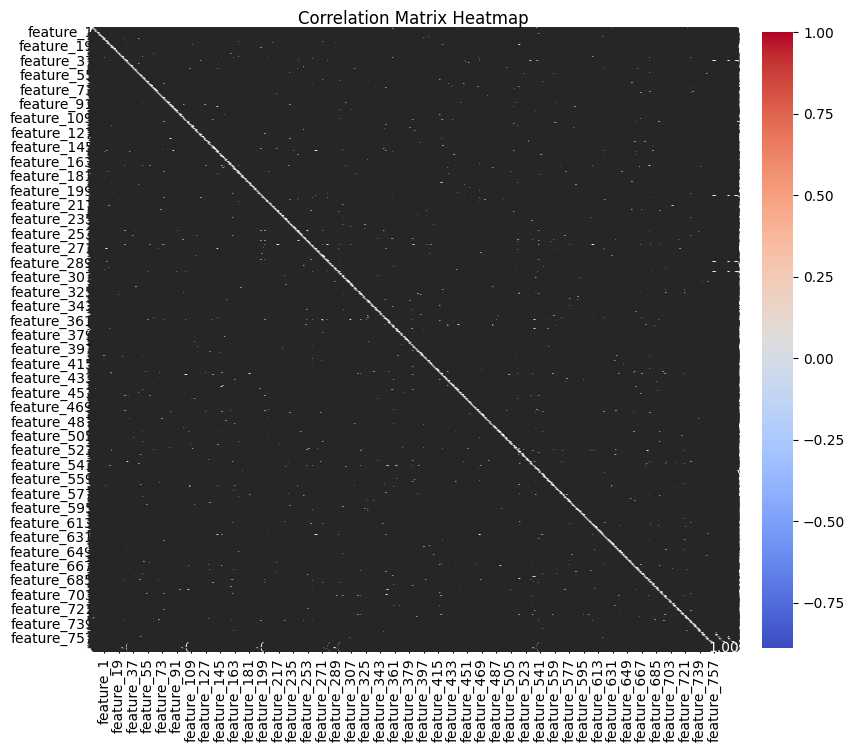

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for X_train
corr_matrix = X_train.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [8]:
#Calculate the correlation in X_train
threshold = 0.9  
correlated_cols = correlation(X_train, threshold)
print(correlated_cols)
#Remove correlated columns from X_train, X_valid, and X_test
X_train = X_train.drop(columns=correlated_cols)
X_valid = X_valid.drop(columns=correlated_cols)
X_test = X_test.drop(columns=correlated_cols)


set()


In [26]:
#create separate dataframes for each label
x_train = {}
x_valid = {}
y_train = {}
y_valid = {}
x_test = {}
y_test = {}
Labels = ["label_1", "label_2", "label_3", "label_4"]
Features = np.array(train_data.drop(columns=["label_1", "label_2", "label_3", "label_4"]).columns)

for label in Labels:
  tr_data = train_data[train_data["label_2"].notna()] if label == "label_2" else train_data
  vl_data = valid_data[valid_data["label_2"].notna()] if label == "label_2" else valid_data

  #standardize data
  scaler = StandardScaler()

  x_train[label] = pd.DataFrame(scaler.fit_transform(tr_data.drop(Labels, axis=1)), columns=Features)
  y_train[label] = tr_data[label]
  x_valid[label] = pd.DataFrame(scaler.transform(vl_data.drop(Labels, axis=1)), columns=Features)
  y_valid[label] = vl_data[label]
  x_test[label] = pd.DataFrame(scaler.transform(test_data.drop(["ID"], axis=1)), columns=Features)


Removing Correlated features

In [27]:
for label in Labels:
    # Calculate the correlation matrix for the x_train[label]
    corr_features = correlation(x_train[label], threshold=0.9)  # Adjust the threshold as needed

    # Remove correlated features from x_train[label]
    x_train[label] = x_train[label].drop(columns=corr_features)
    x_valid[label] = x_valid[label].drop(columns=corr_features)
    x_test[label] = x_test[label].drop(columns=corr_features)

<h4>Label 1</h4>

In [28]:
###### Initial accuracy with svm_model
svm_model_1 = SVC(kernel="linear")
svm_model_1.fit(x_train["label_1"], y_train["label_1"])
accuracy_label_1 = AccuracyScore(svm_model_1, x_valid["label_1"], y_valid["label_1"])


Accuracy: 95.60%


In [29]:
#Apply PCA -Feature Extraction
pca_label_1 = PCA(n_components=0.99, svd_solver="full")
pca_label_1.fit(x_train["label_1"])
x_train_label_1_PCA = pd.DataFrame(pca_label_1.transform(x_train["label_1"]))
print(x_train_label_1_PCA.shape)
x_valid_label_1_PCA = pd.DataFrame(pca_label_1.transform(x_valid["label_1"]))


(28520, 578)


In [30]:
svm_model_1.fit(x_train_label_1_PCA, y_train["label_1"])
acc_pca = AccuracyScore(svm_model_1, x_valid_label_1_PCA, y_valid["label_1"])

Accuracy: 95.87%


In [31]:
param_dist = {
    'C': [100, 10, 1],  # Continuous uniform distribution for 'C'
    'kernel': ['rbf', 'linear'],  # Categorical distribution for 'kernel'
    'gamma': [0.001, 0.01, 0.1],  # Continuous uniform distribution for 'gamma'
    'degree': [2, 3, 4, 5],  # Polynomial degree for 'poly' kernel
    'coef0': [0.0, 1.0, 2.0],  # Independent term in the kernel function
}

# Create a RandomizedSearchCV object
random_search_label_1 = RandomizedSearchCV(svm_model_1, param_dist, cv=5, scoring='accuracy',
                              n_iter=5, random_state=42, verbose=3, n_jobs=-1)
random_search_label_1.fit(x_train_label_1_PCA, y_train['label_1'])
print("Best Hyperparameters:", random_search_label_1.best_params_)

# Get the best hyperparameters and the corresponding model
best_model_label_1 = random_search_label_1.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[CV 1/5] END C=1, coef0=2.0, degree=3, gamma=0.01, kernel=linear;, score=0.949 total time= 1.6min
[CV 2/5] END C=1, coef0=2.0, degree=3, gamma=0.01, kernel=linear;, score=0.950 total time= 1.7min
[CV 2/5] END C=1, coef0=2.0, degree=5, gamma=0.01, kernel=linear;, score=0.950 total time= 1.7min
[CV 5/5] END C=1, coef0=2.0, degree=3, gamma=0.01, kernel=linear;, score=0.946 total time= 1.7min
[CV 4/5] END C=1, coef0=2.0, degree=3, gamma=0.01, kernel=linear;, score=0.947 total time= 1.8min
[CV 3/5] END C=1, coef0=2.0, degree=3, gamma=0.01, kernel=linear;, score=0.945 total time= 1.8min
[CV 3/5] END C=1, coef0=2.0, degree=5, gamma=0.01, kernel=linear;, score=0.945 total time= 1.8min
[CV 1/5] END C=1, coef0=2.0, degree=5, gamma=0.01, kernel=linear;, score=0.949 total time= 1.8min
[CV 4/5] END C=1, coef0=2.0, degree=5, gamma=0.01, kernel=linear;, score=0.947 total time= 1.0min
[CV 5/5] END C=1, coef0=2.0, degree=5, gamma=0.01, kernel=linear;, score=0.946 total time= 1.1min
[CV 1/5] END C=1, co

In [32]:
# Evaluate the best model on validation set
acc_best_model_label_1 = best_model_label_1.score(x_valid_label_1_PCA, y_valid["label_1"])

print("Validation Accuracy with Best Model:", acc_best_model_label_1)


Validation Accuracy with Best Model: 0.9813333333333333


In [33]:
#Check accuracy with tuned model on validation set
svm_model_1_tuned = SVC(kernel="rbf", C=100, gamma=0.001,degree=5,coef0=2.0)
svm_model_1_tuned.fit(x_train_label_1_PCA, y_train["label_1"])
accuracy_label_1 = AccuracyScore(svm_model_1_tuned, x_valid_label_1_PCA, y_valid["label_1"])

Accuracy: 98.27%


In [34]:
#Predict on test set with tuned model and PCA
y_pred_label_1 = svm_model_1_tuned.predict(pca_label_1.transform(x_test["label_1"]))


In [35]:
prediction_df=pd.DataFrame({"ID": id, "label_1": y_pred_label_1})
prediction_df

,ID,label_1
0,1,26
1,2,18
2,3,16
3,4,7
4,5,58
...,...,...
739,740,46
740,741,35
741,742,54
742,743,38


<h4>Label 2</h4>

In [36]:
svm_model_2 = SVC()
svm_model_2.fit(x_train["label_2"], y_train["label_2"])
acc = AccuracyScore(
    svm_model_2, x_valid["label_2"], y_valid["label_2"])


Accuracy: 92.39%


In [37]:
pca_label_2 = PCA(n_components=0.99, svd_solver="full")
pca_label_2.fit(x_train["label_2"])
x_train_label2_PCA = pd.DataFrame(pca_label_2.transform(x_train["label_2"]))
print(x_train_label2_PCA.shape)
x_valid_label2_PCA = pd.DataFrame(pca_label_2.transform(x_valid["label_2"]))


(28040, 578)


In [38]:
svm_model_2.fit(x_train_label2_PCA, y_train["label_2"])
acc = AccuracyScore(svm_model_2, x_valid_label2_PCA, y_valid["label_2"])


Accuracy: 91.85%


In [39]:
param_grid = {
    'C': [100, 10, 1, 0.1],  # Continuous uniform distribution for 'C'
    'kernel': ['rbf', 'linear'],  # Categorical distribution for 'kernel'
    'gamma': [0.001, 0.01, 0.1, 1],  # Continuous uniform distribution for 'gamma'
    'degree': [2, 3, 4, 5],  # Polynomial degree for 'poly' kernel
    'coef0': [0.0, 0.5, 1.0, 2.0]  # Independent term in the kernel function
}
random_search_label_2 = RandomizedSearchCV(svm_model_1, param_grid, cv=5, scoring='accuracy',
                              n_iter=5, random_state=42, verbose=3, n_jobs=-1)
random_search_label_2.fit(x_train_label2_PCA, y_train['label_2'])
print("Best Hyperparameters:", random_search_label_2.best_params_)

# Get the best hyperparameters and the corresponding model
best_model_label_1 = random_search_label_2.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.395 total time= 2.3min
[CV 3/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.600 total time= 2.5min
[CV 2/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.541 total time= 2.5min
[CV 5/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.423 total time= 2.4min
[CV 4/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.602 total time= 2.7min
[CV 3/5] END C=100, coef0=2.0, degree=2, gamma=1, kernel=rbf;, score=0.170 total time=11.4min
[CV 2/5] END C=100, coef0=2.0, degree=2, gamma=1, kernel=rbf;, score=0.170 total time=12.0min
[CV 4/5] END C=100, coef0=2.0, degree=2, gamma=1, kernel=rbf;, score=0.170 total time=12.4min
[CV 5/5] END C=100, coef0=2.0, degree=2, gamma=1, kernel=rbf;, score=0.170 total time=12.6min
[CV 1/5] END C=100, coef0=2.0, degree=2, gamma=1, kernel=rbf;, s

In [40]:
svm_model_2_tuned = SVC(kernel='linear', C=0.1, gamma=0.01,coef0=0.5,degree=4)
svm_model_2_tuned.fit(x_train["label_2"], y_train["label_2"])
acc = AccuracyScore(svm_model_2_tuned, x_valid["label_2"], y_valid["label_2"])


Accuracy: 83.70%


In [41]:
##Check accuracy with best model on validation set with PCA
acc_best_model_label_2 = AccuracyScore(best_model_label_1, x_valid_label2_PCA, y_valid["label_2"])

Accuracy: 82.61%


In [45]:
#Predict on test set with tuned model without PCA
y_pred_label_2 = svm_model_2_tuned.predict(x_test["label_2"])
y_pred_label_df_2=pd.DataFrame(y_pred_label_2, columns=['label_2'])

In [61]:
merge_df=pd.concat([prediction_df, y_pred_label_df_2],axis=1)

In [62]:
merge_df

,ID,label_1,label_2
0,1,26,22.0
1,2,18,25.0
2,3,16,30.0
3,4,7,25.0
4,5,58,29.0
...,...,...,...
739,740,46,30.0
740,741,35,24.0
741,742,54,27.0
742,743,38,32.0


<h4>Label 3</h4>

In [48]:
svm_model_3 = SVC(kernel="linear")
svm_model_3.fit(x_train["label_3"], y_train["label_3"])
acc = AccuracyScore(
    svm_model_3, x_valid["label_3"], y_valid["label_3"])

Accuracy: 99.73%


In [49]:
#Apply PCA - Feature Extraction
pca_label_3 = PCA(n_components=0.95, svd_solver="full")
pca_label_3.fit(x_train["label_3"])
x_train_label_3_PCA = pd.DataFrame(pca_label_3.transform(x_train["label_3"]))
print(x_train_label_3_PCA.shape)
x_valid_label_3_PCA = pd.DataFrame(pca_label_3.transform(x_valid["label_3"]))

(28520, 321)


In [50]:
svm_model_3.fit(x_train_label_3_PCA, y_train["label_3"])
acc = AccuracyScore(svm_model_3, x_valid_label_3_PCA, y_valid["label_3"])

Accuracy: 99.47%


In [51]:
param_grid = {
    'C': [100, 10, 1, 0.1],  # Continuous uniform distribution for 'C'
    'kernel': ['rbf', 'linear'],  # Categorical distribution for 'kernel'
    'gamma': [0.001, 0.01, 0.1, 1],  # Continuous uniform distribution for 'gamma'
    'degree': [2, 3, 4, 5],  # Polynomial degree for 'poly' kernel
    'coef0': [0.0, 0.5, 1.0, 2.0]  # Independent term in the kernel function
}

In [54]:
random_search_label_3 = RandomizedSearchCV(svm_model_3, param_grid, cv=5, scoring='accuracy',
                              n_iter=5, random_state=42, verbose=3, n_jobs=-1)
random_search_label_3.fit(x_train_label_3_PCA, y_train['label_3'])
print("Best Hyperparameters:", random_search_label_3.best_params_)

# Get the best hyperparameters and the corresponding model
best_model_label_3 = random_search_label_3.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[CV 1/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.968 total time=   6.6s
[CV 2/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.991 total time=   8.0s
[CV 3/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.984 total time=   8.4s
[CV 4/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.979 total time=   6.7s
[CV 5/5] END C=0.1, coef0=0.5, degree=4, gamma=0.01, kernel=linear;, score=0.996 total time=   8.4s
[CV 2/5] END C=1, coef0=1.0, degree=5, gamma=0.1, kernel=rbf;, score=0.799 total time=13.4min
[CV 1/5] END C=1, coef0=1.0, degree=5, gamma=0.1, kernel=rbf;, score=0.799 total time=15.4min
[CV 3/5] END C=1, coef0=1.0, degree=5, gamma=0.1, kernel=rbf;, score=0.799 total time=15.5min
[CV 4/5] END C=1, coef0=1.0, degree=5, gamma=0.1, kernel=rbf;, score=0.799 total time=14.1min
[CV 1/5] END C=1, coef0=0.0, degree=3, gamma=1, kernel=rbf;, score=0.799 total time=13.1min
[CV 3/5] END C=100, coef0=2.0, d

In [55]:
best_model_label_3 = random_search_label_3.best_estimator_
acc_best_model_label_3 = AccuracyScore(best_model_label_3, x_valid_label_3_PCA, y_valid["label_3"])

Accuracy: 99.33%


In [56]:
##Check accuracy with tuned model on validation set without PCA
svm_model_3_tuned = SVC(kernel='linear', C=0.1, gamma=0.01,degree=4,coef0=0.5)
svm_model_3_tuned.fit(x_train["label_3"], y_train["label_3"])
acc = AccuracyScore(svm_model_3_tuned, x_valid["label_3"], y_valid["label_3"])

Accuracy: 99.73%


In [58]:
#Predict on test set with tuned model without PCA
y_pred_label_3 = svm_model_3_tuned.predict(x_test["label_3"])
y_pred_label_df_3=pd.DataFrame(y_pred_label_3, columns=['label_3'])

In [63]:
merge_df=pd.concat([merge_df, y_pred_label_df_3],axis=1)

In [64]:
merge_df

,ID,label_1,label_2,label_3
0,1,26,22.0,0
1,2,18,25.0,1
2,3,16,30.0,1
3,4,7,25.0,1
4,5,58,29.0,0
...,...,...,...,...
739,740,46,30.0,1
740,741,35,24.0,1
741,742,54,27.0,1
742,743,38,32.0,1


<h4>Label 4</h4>

In [65]:
svm_model_4 = SVC()
svm_model_4.fit(x_train["label_4"], y_train["label_4"])
acc = AccuracyScore(svm_model_4, x_valid["label_4"], y_valid["label_4"])

Accuracy: 94.93%


In [66]:
pca_label_4 = PCA(n_components=0.95, svd_solver="full")
pca_label_4.fit(x_train["label_4"])
x_train_label_4_PCA = pd.DataFrame(pca_label_4.transform(x_train["label_4"]))
print(x_train_label_4_PCA.shape)
x_valid_label_4_PCA = pd.DataFrame(pca_label_4.transform(x_valid["label_4"]))

(28520, 321)


In [67]:
svm_model_4.fit(x_train_label_4_PCA, y_train["label_4"])
acc = AccuracyScore(svm_model_4, x_valid_label_4_PCA, y_valid["label_4"])


Accuracy: 94.93%


In [68]:
param_grid = {
    'C': [100, 10, 1],  # Continuous uniform distribution for 'C'
    'kernel': ['rbf', 'linear'],  # Categorical distribution for 'kernel'
    'gamma': [0.001, 0.01, 0.1],  # Continuous uniform distribution for 'gamma'
    'degree': [2, 3, 4, 5],  # Polynomial degree for 'poly' kernel
    'coef0': [0.0, 1.0, 2.0],  # Independent term in the kernel function
    'class_weight': [None, 'balanced']
}


In [70]:
random_search_label_4 = RandomizedSearchCV(svm_model_4, param_grid, cv=5, scoring='accuracy',
                              n_iter=5, random_state=42, verbose=3, n_jobs=-1)
random_search_label_4.fit(x_train_label_4_PCA, y_train['label_4'])
print("Best Hyperparameters:", random_search_label_4.best_params_)

# Get the best hyperparameters and the corresponding model
best_model_label_4 = random_search_label_4.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[CV 3/5] END C=100, class_weight=balanced, coef0=0.0, degree=2, gamma=0.01, kernel=linear;, score=0.806 total time= 8.0min
[CV 2/5] END C=100, class_weight=balanced, coef0=0.0, degree=2, gamma=0.01, kernel=linear;, score=0.841 total time=10.6min
[CV 1/5] END C=100, class_weight=balanced, coef0=0.0, degree=2, gamma=0.01, kernel=linear;, score=0.833 total time=13.3min
[CV 1/5] END C=10, class_weight=None, coef0=1.0, degree=4, gamma=0.001, kernel=rbf;, score=0.947 total time= 1.9min
[CV 2/5] END C=10, class_weight=None, coef0=1.0, degree=4, gamma=0.001, kernel=rbf;, score=0.940 total time= 1.9min
[CV 3/5] END C=10, class_weight=None, coef0=1.0, degree=4, gamma=0.001, kernel=rbf;, score=0.948 total time= 1.8min
[CV 4/5] END C=100, class_weight=balanced, coef0=0.0, degree=2, gamma=0.01, kernel=linear;, score=0.827 total time=11.6min
[CV 5/5] END C=100, class_weight=balanced, coef0=0.0, degree=2, gamma=0.01, kernel=linear;, score=0.796 total time= 9.8min
[CV 4/5] END C=10, class_weight=None,

In [71]:


acc_best_model_label_4 = AccuracyScore(best_model_label_4, x_valid_label_4_PCA, y_valid["label_4"])

Accuracy: 97.87%


In [72]:
##Check accuracy with tuned model on validation set with PCA
svm_model_4_tuned = SVC(kernel='rbf', C=100, gamma=0.001)
svm_model_4_tuned.fit(x_train_label_4_PCA, y_train["label_4"])
acc = AccuracyScore(svm_model_4_tuned, x_valid_label_4_PCA, y_valid["label_4"])


Accuracy: 97.07%


In [74]:
##Check accuracy with tuned model on validation set with PCA
svm_model_4_tuned = SVC(kernel='rbf', C=10, gamma=0.001,degree=4,coef0=1.0)
svm_model_4_tuned.fit(x_train_label_4_PCA, y_train["label_4"])
acc = AccuracyScore(svm_model_4_tuned, x_valid_label_4_PCA, y_valid["label_4"])


Accuracy: 97.87%


In [75]:
#Predict on test set with tuned model with PCA
y_pred_label_4 = svm_model_4_tuned.predict(pca_label_4.transform(x_test["label_4"]))
y_pred_label_df_4=pd.DataFrame(y_pred_label_4, columns=['label_3'])

In [76]:
merge_df=pd.concat([merge_df, y_pred_label_df_3],axis=1)

In [77]:
merge_df.to_csv("solutions.csv", index=False)